In [ ]:
import tensorflow as tf
from tensorflow.keras import models,layers
from tensorflow.keras import preprocessing
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import Sequential

In [ ]:
#for image size check the resolution of image in plantvillage folder 
IMAGE_SIZE = 256
BATCH_SIZE=32
CHANNELS = 3
EPOCHS =50

In [ ]:
#load all the data in tensor
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
    
)

In [ ]:
#saving the classes in a variable
class_names = dataset.class_names
class_names

In [ ]:
len(dataset)

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 1 0 0 1 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

# Visualize some of the images from our dataset

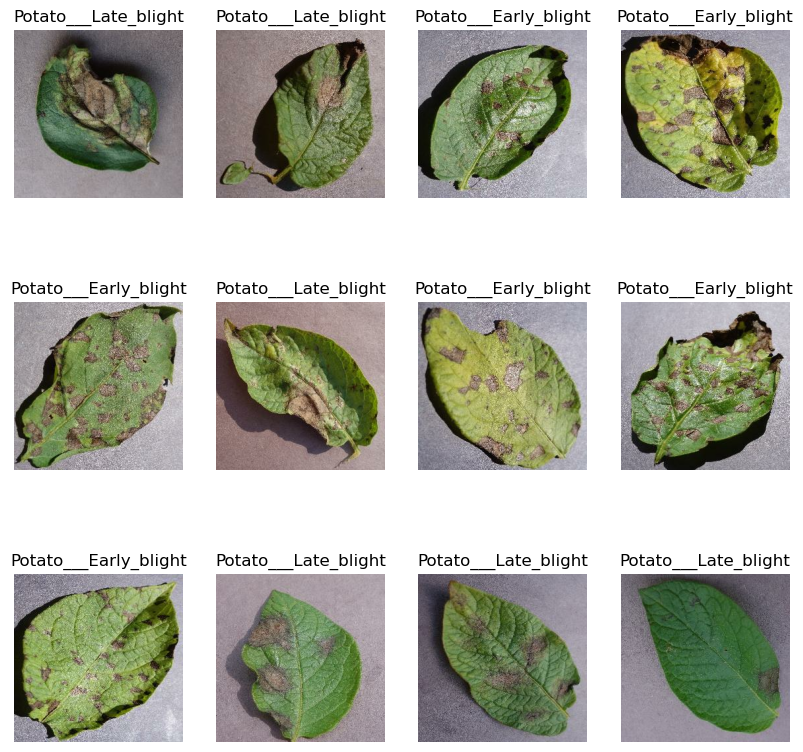

In [9]:
#dataset.take(1) takes only the first batch from the dataset (you are sampling one batch of images and labels)
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

The code creates a 3x4 grid of subplots, where each subplot contains one image from a batch of 12 images taken from a TensorFlow dataset. The images are converted to a format suitable for display, and each subplot is titled with the corresponding class name.

# Function to split Dataset

In [12]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split =0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size=len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split *ds_size)
    val_size=int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [13]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

# Cache, Shuffle and Prefetch the dataset

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

cache(): Stores the dataset in memory (or on disk) after the first epoch for faster access.

shuffle(1000): Randomly shuffles the data with a buffer size of 1000 elements.

prefetch(buffer_size=tf.data.AUTOTUNE): Asynchronously loads batches to overlap data preparation and training, reducing wait time.

This combination of caching, shuffling, and prefetching is commonly used to optimize input pipelines for model training, making data loading faster and more efficient.

# Building the model

## Creating a Layer for Resizing and Normalization

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [20]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),     
    layers.Rescaling(1./255)                      
])

In [21]:
data_augmentation =tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [22]:
train_ds = train_ds.map(
    lambda x,y:(data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE

# Model Architecture

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [25]:
n_classes = 3

model = models.Sequential([
    layers.InputLayer(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), batch_size=BATCH_SIZE),  # Specify input with batch size
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])


model.summary()


C:\Users\DeLL\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)


Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.5004 - loss: 1.8340 - val_accuracy: 0.5938 - val_loss: 0.7963
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.6784 - loss: 0.6346 - val_accuracy: 0.7188 - val_loss: 0.6493
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 666ms/step - accuracy: 0.8363 - loss: 0.3739 - val_accuracy: 0.9583 - val_loss: 0.1527
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 650ms/step - accuracy: 0.9080 - loss: 0.2127 - val_accuracy: 0.9010 - val_loss: 0.2035
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 650ms/step - accuracy: 0.9168 - loss: 0.2051 - val_accuracy: 0.9167 - val_loss: 0.2135
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 649ms/step - accuracy: 0.9460 - loss: 0.1693 - val_accuracy: 0.9635 - val_loss: 0.1014
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 653ms/step - accuracy: 0.9347 - loss: 0.1739 - val_accuracy: 0.8385 - val_loss: 0.3406
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 650ms/step - accuracy: 0.9186 - loss: 0.2007 - val_accuracy:

In [27]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - accuracy: 0.9954 - loss: 0.0198


In [28]:
scores

[0.031027348712086678, 0.9921875]

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

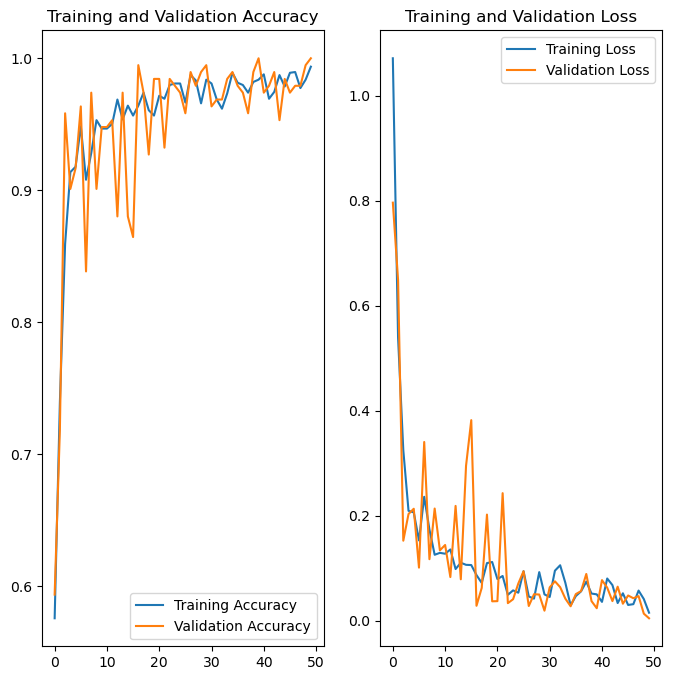

In [30]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Run prediction on a sample image

The code takes a batch of images and labels from the test dataset.

It selects the first image in the batch, displays it, and prints its actual label (from the ground truth).

The model is then used to predict the class of the first image, and the predicted label is printed.

The np.argmax() function is used to select the class with the highest probability from the model's prediction.

This allows you to see how well the model is performing by visually comparing the actual label and predicted label for a single image.

First image to predict 
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
predicted label :  Potato___Early_blight


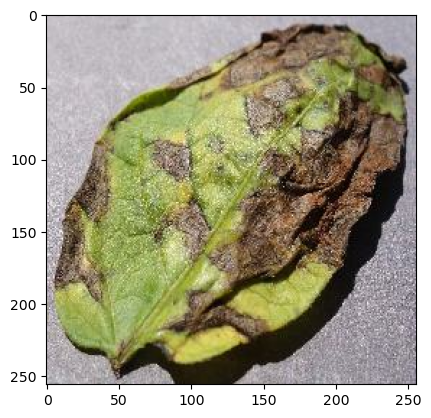

In [33]:
import numpy as np
for image_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First image to predict ")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("predicted label : ",class_names[np.argmax(batch_prediction[0])])
    #np.argmax return the index with maximum value

# Write a function for inference

In [35]:
def  predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


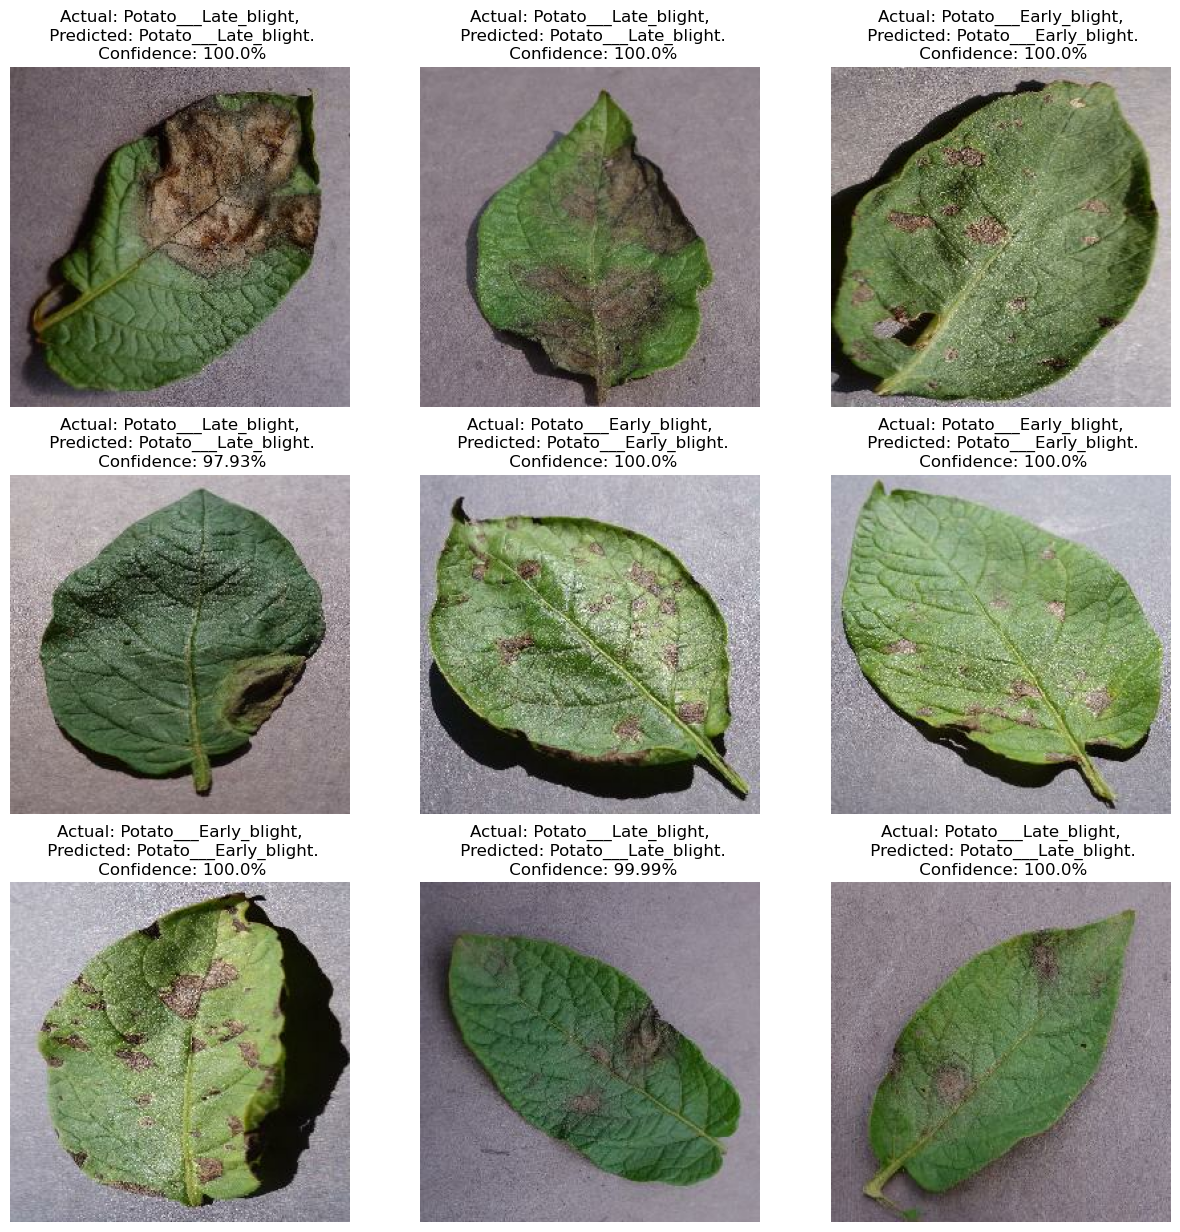

In [36]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Saving the model

In [68]:
import os

# Define the model directory path
model_dir = r"C:\Users\DeLL\Desktop\python files\potato leaf disease\models"

# Filter out non-numeric names and calculate the max version
model_version = (
    max([int(i) for i in os.listdir(model_dir) if i.isdigit()] + [0]) + 1
)

print(f"Next model version: {model_version}")
model.save(os.path.join(model_dir, f"{model_version}.keras"))



Next model version: 1
